In [210]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as scispec

In [211]:
# Based on https://opg.optica.org/ol/fulltext.cfm?uri=ol-32-8-970&id=131277
# We will used x polarisation althought this could be done for y or z (would y be different? Better?)
# In polar coordinates

In [212]:
15.3/8.5

1.8

In [413]:
c = 3*10**8
eps0 = 8.854*10**(-12)
wavelength = 1064*10**(-9)
omega = 2*np.pi*c/wavelength
n1 = 1.5
n3 = 1.5
k0 = omega/c
k1 = k0*n1
k3 = k0*n3
f1 = 1.4*10**(-3) # this is the vienna value for now based on a magnification of 8.5 being best
f3 = 15.3*10**(-3) # just a value for now
M = f3/f1 # Magnification - f3 is the variable we want to optimise
print(M)
z3 = 0 #?????? position of fibre, origin at dipole??????
rho3 = 0 #?????? think this is coordinate (polar) so 0 when not displaced 

10.928571428571429


In [414]:
def g_theta(theta):
    g = (1-(np.sin(theta)/M)**2)**(1/2)
    return g

def f_theta(theta):
    f = np.exp(1j*k3*z3*g_theta(theta))*(np.cos(theta)/g_theta(theta))**(1/2)*np.sin(theta)
    return f

In [415]:
NA = 0.95
thetamax = np.arcsin(NA)
theta = np.linspace(0, thetamax, 1000)
C = 1j*k0**3*(n1*n3)**(1/2)*np.exp(1j*f1*(k1-k3*M))/(8*np.pi*M*eps0)
rho3 = np.linspace(0, 25*10**(-6), 1000)
Id0 = []
Id2 = []
Id12 = []
ft = f_theta(theta)
gt = g_theta(theta)
ct = np.cos(theta)
st = np.sin(theta)
for i in rho3:
    arg = 1.3*k0*i/M*np.sin(theta)
    Id0_tmp = np.trapz(ft*(1+ct*gt)*scispec.jv(0, arg), theta) # integral over theta
    Id2_tmp = np.trapz(ft*(1-ct*gt)*scispec.jv(2, arg), theta) # integral over theta
    Id12_tmp = np.trapz(ft*ct*st*M**(-2)*scispec.jv(1, arg), theta) # integral over theta
    Id0.append(Id0_tmp)
    Id2.append(Id2_tmp)
    Id12.append(Id12_tmp)

In [416]:
### What is dx??? Dipole? Let's say it's all in x
phi3l = np.linspace(0, 2*np.pi, 100) #???
#phi3 = np.pi
dx = 1
Ex3_r_l = []
Ex3_theta_l = []
Ex3_phi_l = []
for phi3 in phi3l:
    Ex3_r = C*dx*(np.array(Id0) + np.array(Id2)*np.cos(2*phi3)) # Id0 and Id2 are integrals, phi3 is phi coordiante for fibre objective lens
    Ex3_theta = C*dx*(np.array(Id2)*np.sin(2*phi3)) 
    Ex3_phi = C*dx*(-2j*np.array(Id12)*np.sin(2*phi3)) # Id12 is integrals
    Ex3_r_l.append(Ex3_r)
    Ex3_theta_l.append(Ex3_theta)
    Ex3_phi_l.append(Ex3_phi)

In [417]:
# Now fibre mode electric field
a = 2.5*10**(-6)
r = np.linspace(0, a, 1000)
nco = 1.45
ncl = 1.44
beta = nco*k0*0.9968
u = a*np.sqrt(nco**2*k0**2 - beta**2)
w = a*np.sqrt(beta**2 - ncl**2*k0**2)
print(np.sqrt(w**2+u**2))
arg2 = u*r/a
Ex_01 = scispec.jv(0, arg2) # r<a
r2 = np.linspace(a, 20*10**(-6), 9000)
Ex_01_2 = scispec.jv(0, u)/scispec.kv(0, w)*scispec.kv(0, w*r2/a) # r>a
sum_E = np.sum(Ex_01)+np.sum(Ex_01_2)
#Ex_01 = Ex_01/sum_E
#Ex_01_2 = Ex_01_2/sum_E

2.5097309732625366


In [418]:
1.29/1.3

0.9923076923076923

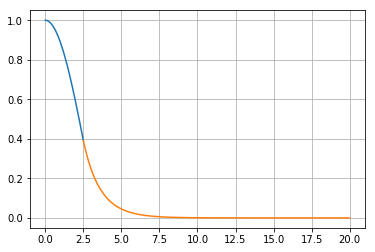

In [419]:
plt.figure()
plt.grid()
plt.plot(r*10**6, Ex_01) ###########There is an additiona **0.7 here#########
plt.plot(r2*10**6, Ex_01_2) ###########There is an additiona **0.7 here#########


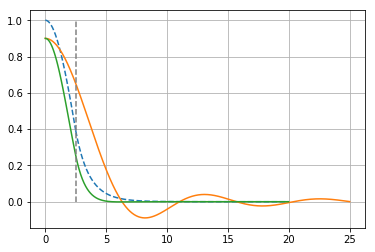

In [420]:
plt.figure()
plt.grid()
plt.plot(r*10**6, Ex_01, '--') ###########There is an additiona **0.7 here#########
plt.plot(r2*10**6, Ex_01_2, '--', color = 'tab:blue') ###########There is an additiona **0.7 here#########
plt.plot(rho3*10**6, 0.9*Ex3_r_l[0]/Ex3_r_l[0][0])
plt.plot(r[::10]*10**6, 0.9*Ex_01[::10]*Ex3_r_l[0][:100]/Ex3_r_l[0][0])
plt.plot(r2[::10]*10**6, 0.9*Ex_01_2[::10]*Ex3_r_l[0][100:]/Ex3_r_l[0][0], color = 'tab:green')
plt.plot([a*10**6, a*10**6], [0, 1], '--', color = 'gray')
#plt.plot(rho3*10**6, 10**(-32)*Ex3_phi)
#plt.plot(rho3*10**6, 10**(-32)*Ex3_theta)

In [421]:
overlapl = []
for i in range(len(phi3l)):
    overlap_tmp = np.abs(np.trapz(Ex_01[::10]*Ex3_r_l[i][:100], r[::10]) + np.trapz(Ex_01_2[::10]*Ex3_r_l[i][100:], r2[::10]))
    #overlap_tmp = np.abs(np.trapz(Ex_01[::10]*Ex3_r_l[i][:100], r[::10]))
    overlapl.append(overlap_tmp)
overlap = np.trapz(overlapl, phi3l)**2
print(overlap)

2.0770421846500254e+48


In [422]:
dipolel = []
for i in range(len(phi3l)):
    dipole_tmp = np.trapz(np.abs(Ex3_r_l[i])**2, rho3)
    dipolel.append(dipole_tmp)
dipole = np.trapz(dipolel, phi3l)

In [423]:
fibrel = []
for i in range(len(phi3l)):
    fibre_tmp = (np.trapz(Ex_01**2, r) + np.trapz(Ex_01_2**2, r2))
    fibrel.append(fibre_tmp)
fibre = np.trapz(fibrel, phi3l)

In [424]:
overlap/dipole/fibre

0.8772568662350537

In [451]:
c = 3*10**8
eps0 = 8.854*10**(-12)
wavelength = 1064*10**(-9)
omega = 2*np.pi*c/wavelength
n1 = 1.5
n3 = 1.5
k0 = omega/c
k1 = k0*n1
k3 = k0*n3
f1 = 1.4*10**(-3) # this is the vienna value for now based on a magnification of 8.5 being best
f3 = 15.3*10**(-3) # just a value for now
M = f3/f1 # Magnification - f3 is the variable we want to optimise
print(M)
z3 = 0 #?????? position of fibre, origin at dipole??????
rho3 = 0 #?????? think this is coordinate (polar) so 0 when not displaced 
etal = []
for M in np.arange(4, 20, 0.25):
    NA = 0.95
    thetamax = np.arcsin(NA)
    theta = np.linspace(0, thetamax, 1000)
    C = 1j*k0**3*(n1*n3)**(1/2)*np.exp(1j*f1*(k1-k3*M))/(8*np.pi*M*eps0)
    rho3 = np.linspace(0, 25*10**(-6), 1000)
    Id0 = []
    Id2 = []
    Id12 = []
    ft = f_theta(theta)
    gt = g_theta(theta)
    ct = np.cos(theta)
    st = np.sin(theta)
    for i in rho3:
        arg = 1.3*k0*i/M*np.sin(theta)
        Id0_tmp = np.trapz(ft*(1+ct*gt)*scispec.jv(0, arg), theta) # integral over theta
        Id2_tmp = np.trapz(ft*(1-ct*gt)*scispec.jv(2, arg), theta) # integral over theta
        Id12_tmp = np.trapz(ft*ct*st*M**(-2)*scispec.jv(1, arg), theta) # integral over theta
        Id0.append(Id0_tmp)
        Id2.append(Id2_tmp)
        Id12.append(Id12_tmp)
    ### What is dx??? Dipole? Let's say it's all in x
    phi3l = np.linspace(0, 2*np.pi, 100) #???
    #phi3 = np.pi
    dx = 1
    Ex3_r_l = []
    Ex3_theta_l = []
    Ex3_phi_l = []
    for phi3 in phi3l:
        Ex3_r = C*dx*(np.array(Id0) + np.array(Id2)*np.cos(2*phi3)) # Id0 and Id2 are integrals, phi3 is phi coordiante for fibre objective lens
        Ex3_theta = C*dx*(np.array(Id2)*np.sin(2*phi3)) 
        Ex3_phi = C*dx*(-2j*np.array(Id12)*np.sin(2*phi3)) # Id12 is integrals
        Ex3_r_l.append(Ex3_r)
        Ex3_theta_l.append(Ex3_theta)
        Ex3_phi_l.append(Ex3_phi)
    # Now fibre mode electric field
    a = 2.5*10**(-6)
    r = np.linspace(0, a, 1000)
    nco = 1.45
    ncl = 1.44
    beta = nco*k0*0.9968
    u = a*np.sqrt(nco**2*k0**2 - beta**2)
    w = a*np.sqrt(beta**2 - ncl**2*k0**2)
    #print(np.sqrt(w**2+u**2))
    arg2 = u*r/a
    Ex_01 = scispec.jv(0, arg2) # r<a
    r2 = np.linspace(a, 20*10**(-6), 9000)
    Ex_01_2 = scispec.jv(0, u)/scispec.kv(0, w)*scispec.kv(0, w*r2/a) # r>a
    sum_E = np.sum(Ex_01)+np.sum(Ex_01_2)
    #Ex_01 = Ex_01/sum_E
    #Ex_01_2 = Ex_01_2/sum_E
    overlapl = []
    for i in range(len(phi3l)):
        overlap_tmp = np.abs(np.trapz(Ex_01[::10]*Ex3_r_l[i][:100], r[::10]) + np.trapz(Ex_01_2[::10]*Ex3_r_l[i][100:], r2[::10]))
        #overlap_tmp = np.abs(np.trapz(Ex_01[::10]*Ex3_r_l[i][:100], r[::10]))
        overlapl.append(overlap_tmp)
    overlap = np.trapz(overlapl, phi3l)**2
    dipolel = []
    for i in range(len(phi3l)):
        dipole_tmp = np.trapz(np.abs(Ex3_r_l[i])**2, rho3)
        dipolel.append(dipole_tmp)
    dipole = np.trapz(dipolel, phi3l)
    fibrel = []
    for i in range(len(phi3l)):
        fibre_tmp = (np.trapz(Ex_01**2, r) + np.trapz(Ex_01_2**2, r2))
        fibrel.append(fibre_tmp)
    fibre = np.trapz(fibrel, phi3l)
    eta = overlap/dipole/fibre
    etal.append(eta)
    #print('yes')

10.928571428571429


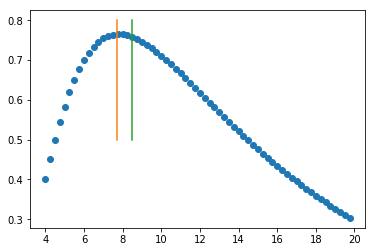

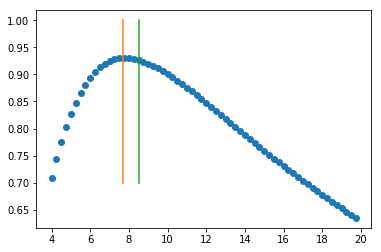

In [457]:
plt.plot(np.arange(4, 20, 0.25),np.array(etal[:])**2-0.1, 'o')
plt.plot([7.7, 7.7], [0.5, 0.8])
plt.plot([8.5, 8.5], [0.5, 0.8])

plt.figure()
plt.plot(np.arange(4, 20, 0.25),np.array(etal[:]), 'o')
plt.plot([7.7, 7.7], [0.7, 1.0])
plt.plot([8.5, 8.5], [0.7, 1.0])

In [460]:
foo = np.arange(4, 20, 0.25)
foo[np.argmax(etal)]

7.75

In [84]:
print(np.mean(overlapl))
print(overlap)
print(np.mean(dipolel))
print(dipole)
print(np.mean(fibrel))
print(fibre)

2.74283819291681e+46
1.7231937577389854e+47
2.1356733625813158e+52
1.3415201435230025e+53
1.5001750706511327e-06
9.425877962112296e-06


In [85]:
8.90297323432921e+45/1.5044364881908995e+52/1.27116741756295e-06

0.46554155945601544

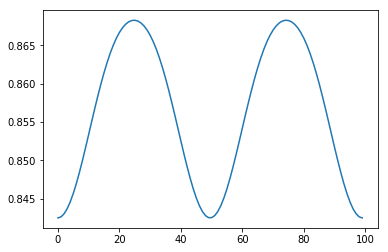

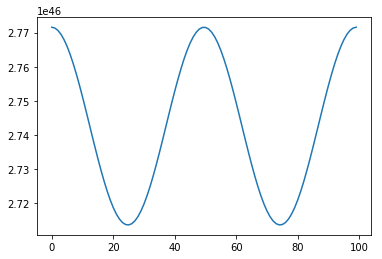

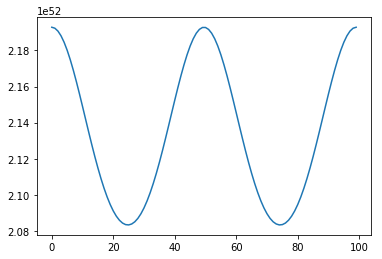

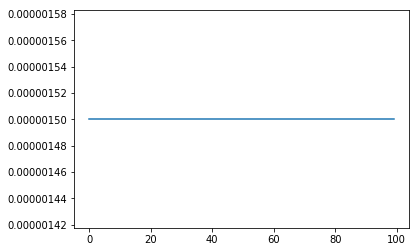

In [86]:
plt.plot(np.array(overlapl)/np.array(dipolel)/np.array(fibrel))
plt.figure()
plt.plot(overlapl)
plt.figure()
plt.plot(dipolel)
plt.figure()
plt.plot(fibrel)

In [368]:
c = 3*10**8
eps0 = 8.854*10**(-12)
wavelength = 1064*10**(-9)
omega = 2*np.pi*c/wavelength
n1 = 1.5
n3 = 1.5
k0 = omega/c
k1 = k0*n1
k3 = k0*n3
f1 = 1.8*10**(-3) # this is the vienna value for now based on a magnification of 8.5 being best
f3 = np.linspace(1, 20, 10)*f1 # just a value for now
mag = f3/f1 # Magnification - f3 is the variable we want to optimise
z3 = 0 #?????? position of fibre, origin at dipole??????
rho3 = 0 #?????? think this is coordinate (polar) so 0 when not displaced 

In [379]:
eta = []
eta2 = []
eta3 = []
for M in mag:
    NA = 0.95
    thetamax = np.arcsin(NA)
    theta = np.linspace(0, thetamax, 1000)
    C = 1j*k0**3*(n1*n3)**(1/2)*np.exp(1j*f1*(k1-k3*M))/(8*np.pi*M*eps0)
    rho3 = np.linspace(0, 20*10**(-6), 1000)
    Id0 = []
    Id2 = []
    Id12 = []
    ft = f_theta(theta)
    gt = g_theta(theta)
    ct = np.cos(theta)
    st = np.sin(theta)
    for i in rho3:
        arg = 1.3*k0*i/M*np.sin(theta)
        Id0_tmp = np.trapz(ft*(1+ct*gt)*scispec.jv(0, arg), theta) # integral over theta
        Id2_tmp = np.trapz(ft*(1-ct*gt)*scispec.jv(2, arg), theta) # integral over theta
        Id12_tmp = np.trapz(ft*ct*st*M**(-2)*scispec.jv(1, arg), theta) # integral over theta
        Id0.append(Id0_tmp)
        Id2.append(Id2_tmp)
        Id12.append(Id12_tmp)

    ### What is dx??? Dipole? Let's say it's all in x
    phi3l = np.linspace(0, 2*np.pi, 1000) #???
    #phi3 = np.pi
    dx = 1
    Ex3_r_l = []
    Ex3_theta_l = []
    Ex3_phi_l = []
    for phi3 in phi3l:
        Ex3_r = C*dx*(np.array(Id0) + np.array(Id2)*np.cos(2*phi3)) # Id0 and Id2 are integrals, phi3 is phi coordiante for fibre objective lens
        Ex3_theta = C*dx*(np.array(Id2)*np.sin(2*phi3)) 
        Ex3_phi = C*dx*(-2j*np.array(Id12)*np.sin(2*phi3)) # Id12 is integrals
        Ex3_r_l.append(Ex3_r)
        Ex3_theta_l.append(Ex3_theta)
        Ex3_phi_l.append(Ex3_phi)
    # Now fibre mode electric field
    a = 2.5*10**(-6)
    r = np.linspace(0, a, 100)
    nco = 1.45
    ncl = 1.44
    beta = nco*k0*0.9968
    u = a*np.sqrt(nco**2*k0**2 - beta**2)
    w = a*np.sqrt(beta**2 - ncl**2*k0**2)
    #print(np.sqrt(w**2+u**2))
    arg2 = u*r/a
    Ex_01 = scispec.jv(0, arg2) # r<a
    r2 = np.linspace(a, 20*10**(-6), 900)
    Ex_01_2 = scispec.jv(0, u)/scispec.kv(0, w)*scispec.kv(0, w*r2/a) # r>a
    sum_E = np.sum(Ex_01)+np.sum(Ex_01_2)
    #Ex_01 = Ex_01/sum_E
    #Ex_01_2 = Ex_01_2/sum_E
    
    overlapl = []
    for i in range(len(phi3l)):
        overlap_tmp = np.abs(np.trapz(Ex_01*np.abs(Ex3_r_l[i][:100]), r) + np.trapz(Ex_01_2*np.abs(Ex3_r_l[i][100:]), r2))
        overlapl.append(overlap_tmp)
    overlap = np.trapz(overlapl, phi3l)**2
    dipolel = []
    for i in range(len(phi3l)):
        dipole_tmp = np.trapz(np.abs(Ex3_r_l[i])**2, rho3)
        dipolel.append(dipole_tmp)
    dipole = np.trapz(dipolel, phi3l)
    fibrel = []
    for i in range(len(phi3l)):
        fibre_tmp = (np.trapz(np.concatenate((Ex_01, Ex_01_2))**2, np.concatenate((r, r2))))
        fibrel.append(fibre_tmp)
    fibre = np.trapz(fibrel, phi3l)
    
    overlap2 = np.abs(np.trapz(Ex_01[::]*Ex3_r_l[250][:100], r[::]) + np.trapz(Ex_01_2[::]*Ex3_r_l[250][100:], r2[::]))**2
    dipole2 = np.trapz(np.abs(Ex3_r_l[250])**2, rho3)
    fibre2 = (np.trapz(np.concatenate((Ex_01, Ex_01_2))**2, np.concatenate((r, r2))))
    
    overlap3 = np.abs(np.trapz(Ex_01[::]*Ex3_r_l[0][:100], r[::]) + np.trapz(Ex_01_2[::]*Ex3_r_l[0][100:], r2[::]))**2
    dipole3 = np.trapz(np.abs(Ex3_r_l[0])**2, rho3)
    fibre3 = (np.trapz(np.concatenate((Ex_01, Ex_01_2))**2, np.concatenate((r, r2))))
    
    eta.append(overlap/dipole/fibre)
    eta2.append(overlap2/dipole2/fibre2)
    eta3.append(overlap3/dipole3/fibre3)

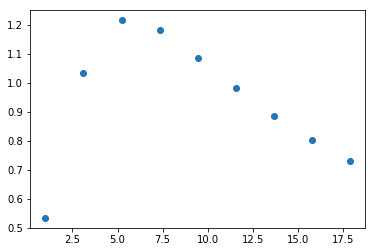

In [380]:
lb = 0
ub = -1
plt.plot(mag[lb:ub], np.array(eta[lb:ub]), 'o')
#plt.plot(mag[lb:ub], eta2[lb:ub], 'o')
#plt.plot(mag[lb:ub], eta3[lb:ub], 'o')

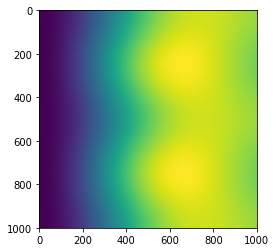

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

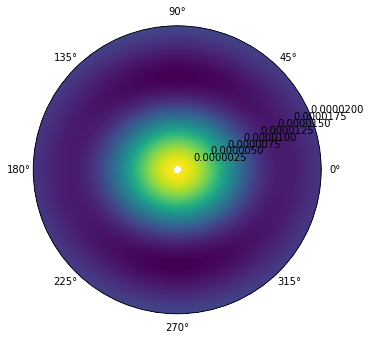

In [115]:
plt.imshow(np.real(Ex3_r_l))
plt.figure()
plt.imshow(np.imag(Ex3_r_l))
plt.clf()
fig = plt.figure(figsize=[5,5])
ax = fig.add_axes([0.1,0.1,0.8,0.8],polar=True)
ax.pcolormesh(phi3l, rho3, np.transpose(np.real(Ex3_r_l)))
plt.clf()
fig = plt.figure(figsize=[5,5])
ax = fig.add_axes([0.1,0.1,0.8,0.8],polar=True)
ax.pcolormesh(phi3l, rho3, np.transpose(np.imag(Ex3_r_l)))